In [1]:
import os
import numpy as np
import time
import re
import math
from itertools import product
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from bottle import template
from IPython.core.display import display, HTML

played = datetime.datetime.now() - datetime.datetime(2018, 7, 10)
print("{} days in game.".format(played.days))

48 days in game.


In [2]:
content = ""
for name in os.listdir("."):
    if name.startswith("游戏记录"):
        with open(name, "r", -1, "UTF-8") as fl:
            content += fl.read() + "\n\n"

In [17]:
default = {"year": 2018, "month": 1, "day": 1}
time_formats = [
    r"(?P<year>\d{4})\.(?P<month>\d+)\.(?P<day>\d+) (?P<hour>\d+):(?P<minute>\d+)",
    r"(?P<year>\d{2})\.(?P<month>\d+)\.(?P<day>\d+) (?P<hour>\d+):(?P<minute>\d+)",
    r"(?P<month>\d+)\.(?P<day>\d+) (?P<hour>\d+):(?P<minute>\d+)",
    r"(?P<year>\d{4})\.(?P<month>\d+)\.(?P<day>\d+)",
    r"(?P<year>\d{2})\.(?P<month>\d+)\.(?P<day>\d+)",
    r"(?P<hour>\d+):(?P<minute>\d+)",
]
def get_date_time(text):
    for fmt in time_formats:
        res = re.search(fmt, text)
        if res:
            default.update({k: int(v) for k, v in res.groupdict().items()})
#             print(text, default)
            if default["year"] < 100:
                default["year"] += 2000
            return datetime.datetime(**default)
#     print(text, None)
    return None

def plot_diff(xs, ys, name):
    last_x = xs[0]
    last_y = ys[0]
    all_x = []
    all_y = []
    for i in range(1, len(xs)):
        x = xs[i]
        y = ys[i]
        if x.day != last_x.day or i == len(xs) - 1:
            dx = (x.timestamp() - last_x.timestamp()) / (3600*24)
            all_x.append(datetime.datetime(x.year, x.month, x.day))
            all_y.append((y-last_y) / dx)
#             print(last_x, x, last_y, y)
            last_x = x
            last_y = y
    
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.bar(all_x, all_y)
    plt.title("{}/day".format(name))
    plt.show()
    
def plot_history(item_id=0):
    check = {
        0: "出击次数",
        1: "油",
        2: "物资",
        3: "当前钻石",
        4: "魔方"
    }[item_id]
    
    first_day = datetime.datetime.now() - datetime.timedelta(days=21)

    items = re.sub("[\r\n]{2,}", "\n\n", content).split("\n\n")
    xs = []
    ys = []
    for item in items:
        now = get_date_time(item)
        count = re.search("%s ?(\d+)" % check, item)
        if count and now and now > first_day:
            count = int(count.group(1))
            xs.append(now)
            ys.append(count)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.plot(xs, ys)
    plt.title(check)
    plt.show()
    plot_diff(xs, ys, check)
        
    return xs, ys

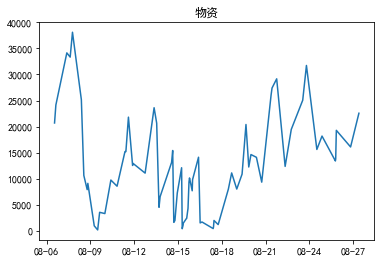

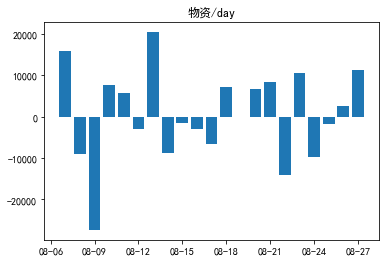

In [18]:
xs, ys = plot_history(2)

In [7]:
items = re.sub("[\r\n]{2,}", "\n\n", content).split("\n\n")
for item in reversed(items):
    now = get_date_time(item)
    count = re.search("出击次数 ?(\d+)", item)
    if count and now:
        count = int(count.group(1))
        days = (now - datetime.datetime(2018, 7, 10)).days
        break
print("{2}天, {1}出击, 平均每天{0:.1f}出击".format(count / days, count, days))

47天, 10666出击, 平均每天226.9出击


In [11]:
print("{:%Y-%m-%d %H:%M}".format(datetime.datetime.now() + datetime.timedelta(hours=5)))

2018-08-26 02:03


In [3]:
def get_time(s):
    each = [int(p) for p in s.split(":")]
    minutes = np.dot(each, [60, 1])
    return minutes

In [7]:
map_count = (8276 - 8175)
time_passed = datetime.datetime(2018, 8, 14, 22, 54) - datetime.datetime(2018, 8, 14, 17, 12)
minutes = time_passed.seconds // 60
print("{:02d}:{:02d} {:.1f}次\n{:.1f}min/次".format(minutes // 60, minutes % 60, map_count, minutes / map_count))

05:42 101.0次
3.4min/次


In [21]:
p_get_per_run = 1.5 / 100
assured_p = 0.95
max_n = 1000

p_not_get_per_run = 1 - p_get_per_run
n = math.ceil(math.log(1 - assured_p) / math.log(p_not_get_per_run))
p_get_wanted_in_n = 1 - p_not_get_per_run ** n

average = math.ceil(1 / p_get_per_run)
print("""
平均需要{0}次
为确保{2:.2%}的几率获得, 需要{1}次
""".strip().format(average, n, p_get_wanted_in_n))

平均需要67次
为确保95.06%的几率获得, 需要199次


In [12]:
context = {
    "road_count": 4,
    "time_road": 30,
    "time_move": 30,
    "time_boss": 80,

    "oil_road": [9,4,2,9,1],
    "oil_boss": [11,9,8,4,7],

    "exp_road": 514,
    "exp_boss": 687,

    "drop_all": 0,
    "drop_boss": 50,
}
def get(key, default=0):
    return context.get(key, default)

def exp_bonus(oil):
    bonus = [1.5, 2]
    for i in oil[2:]:
        bonus.append(1)
    return sum(bonus)
    
context["time_cost"] = get("road_count") * get("time_road") + (get("road_count") + 1) * get("time_move") + get("time_boss")
context["oil_cost"] = get("oil_enter", 10) + sum(get("oil_road")) * get("road_count") + sum(get("oil_boss"))
context["exp_gain"] = get("exp_road") * exp_bonus(get("oil_road")) * get("road_count") + get("exp_boss") * exp_bonus(get("oil_boss"))
context["drop_gain"] = get("drop_all") * (get("road_count") + 1) + get("drop_boss")


for a, b in product(["time_cost", "oil_cost"], ["exp_gain", "drop_gain"]):
    print("{}/{} = {:.3f}".format(b, a, get(b)/get(a)))

exp_gain/time_cost = 50.941
drop_gain/time_cost = 0.143
exp_gain/oil_cost = 119.661
drop_gain/oil_cost = 0.336


In [15]:
(1000000-497500)/((380*2+338*2+303)*1.2*1.5) * 5 * 6/5

963.1972397929845

In [11]:
684/1.5/1.2

380.0

In [119]:
for i in [
# 罗德尼
(132000-81735)/ (514*1.5*1.2),
# Z23
((40000-14100) + (1000000 - 808000)) / (514*2*1.2)
]:
    print(i)

54.32879377431907
176.63748378728926


In [117]:
(132000-131149)

851

In [73]:
start = datetime.datetime.now()
print(start)

2018-07-27 14:18:49.925711


In [130]:
end = datetime.datetime.now()
print(end)
print(end  - start)

2018-07-29 11:51:31.594240
0:11:32.602032


In [86]:
end = datetime.datetime.now()
print(end)
print(end  - start)

2018-07-27 14:26:56.795580
0:08:06.869869


In [92]:
end = datetime.datetime.now()
print(end)
print(end  - start)

2018-07-27 14:49:01.717170
0:30:11.791459


In [85]:
(60*4+30*5+80)/60

7.833333333333333

In [87]:
end = datetime.datetime.now()
print(end)
print(end  - start)

2018-07-27 14:27:07.742881
0:08:17.817170


In [88]:
60/8

7.5

In [ ]:
4400-2950

1450

In [8]:
bonus_ratio([7,10,8,]);
bonus_ratio([7,10,8,4]);
bonus_ratio([8,5,5,3]);
bonus_ratio([8,5,5,4]);

0.180 =4.5/25@[7, 10, 8]
0.190 =5.5/29@[7, 10, 8, 4]
0.262 =5.5/21@[8, 5, 5, 3]
0.250 =5.5/22@[8, 5, 5, 4]


In [13]:
def get_exp_bonus(oil_fight):
    bonus = [1.5, 2]
    for i in oil_fight[2:]:
        bonus.append(1)
    return np.array(bonus)

def get_ratio(oil_fight, oil_enter, exp_base, exp_boss, base_min, base_max, **kwargs):
    """给出油耗信息、关卡经验信息，计算经验/油耗比"""
    bonus = get_exp_bonus(oil_fight)
    print("单次油耗{} 平均油耗{:.1f} 增益/油耗比{:.2f}".format(np.sum(oil_fight), np.mean(oil_fight), bonus.sum()/np.sum(oil_fight)))
    for count in range(base_min, base_max+1):
        exp = (exp_base * count + exp_boss) * bonus.sum()
        oil = oil_enter + np.sum(oil_fight) * (count + 1)
        print("{}次，经验{:.0f}/油耗{} = {:.1f}".format(count, exp, oil, exp/oil))
    print()

def bonus_ratio(oil_fight):
    bonus = get_exp_bonus(oil_fight).sum()
    oil_all = np.sum(oil_fight)
    print("{:.3f} ={:.1f}/{:.0f}@{}".format(bonus / oil_all, bonus, oil_all, oil_fight))
    return bonus / oil_all
    
def next_ratio(exp_history, oil_history, exp_next, oil_next=None, use_size=True):
    """给出当前战斗历史，判断是否继续道中战斗"""
    oil_consume = 10
    exp_gain = 0
    size_exp = np.array([0, 1, 1.1, 1.2]) * 100
    
    if not isinstance(exp_history, (list, tuple)):
        exp_history = [exp_history]
        
    if not isinstance(oil_history, (list, tuple)):
        # 历史油耗信息为数值形式，则认为历史战斗的油耗均为该数值
        oil_history = [oil_history for _ in exp_history]
    print(exp_history, oil_history)
    for exp, oil in zip(exp_history, oil_history):
        oil_consume += oil
        if use_size:
            exp_gain += size_exp[exp]
        else:
            exp_gain += exp
    ratio_now = exp_gain / oil_consume
    
    if not isinstance(exp_next, (list, tuple)):
        exp_next = [exp_next]
    
    if oil_next is None:
        # 未提供此后的油耗信息，则认为之后的油耗与上次战斗相同
        oil_next = [oil_history[-1] for _ in exp_next]
    elif not isinstance(oil_next, (list, tuple)):
        # 油耗信息为数值形式，则认为之后的油耗均为该数值
        oil_next = [oil_next for _ in exp_next]

    for exp, oil in zip(exp_next, oil_next):
        oil_consume += oil
        if use_size:
            exp_gain += size_exp[exp]
        else:
            exp_gain += exp

    ratio = exp_gain / oil_consume
    print("{!s:>5}: {:.2f} vs. {:.2f}".format(ratio >= ratio_now, ratio_now, ratio))

In [14]:
cost = {
    "Enter": 10,
    "Normal": 12,
    "Boss": 14,
}
weight = {
    "NormalDrop": 0,
    "AllDrop": 1,
    "BossDrop": 1,
    "Exp": 1,
}

def gain_cost_compare(weight, cost):
    consumed = cost.get("Enter", 10)
    gain = 0
    normal_cost = cost.get("Normal")
    for i in range(1, 6):
        consumed += normal_cost
        gain += weight.get("Normal", 0)
#         if i < 3:
#             continue
#         print("{0}: {3:.3f}={1:.0f}/{2:.0f}".format(i, gain, consumed, gain / consumed))
        final_gain = gain + weight.get("Boss", 0)
        final_consumed = consumed + cost.get("Boss", normal_cost)
        ratio = final_gain / final_consumed
        print("{0}: {3:.3f}={1:.0f}/{2:.0f}(back) or {6:.3f}={4:.0f}/{5:.0f}(boss)".format(i, gain, consumed, gain / consumed, final_gain, final_consumed, ratio))
        
gain_cost_compare(weight, cost)

1: 0.000=0/22(back) or 0.000=0/36(boss)
2: 0.000=0/34(back) or 0.000=0/48(boss)
3: 0.000=0/46(back) or 0.000=0/60(boss)
4: 0.000=0/58(back) or 0.000=0/72(boss)
5: 0.000=0/70(back) or 0.000=0/84(boss)


In [31]:
map_3_4 = {
    "cost": {
        "Enter": 10,
        "Normal": 20,
        "Boss": 30,
    },
    "weight": {
        "Normal": 337 + 300,
        "Boss": 452 + 300 + 500, 
    }
}
gain_cost_compare(**map_3_4)

1: 21.233=637/30(back) or 31.483=1889/60(boss)
2: 25.480=1274/50(back) or 31.575=2526/80(boss)
3: 27.300=1911/70(back) or 31.630=3163/100(boss)
4: 28.311=2548/90(back) or 31.667=3800/120(boss)
5: 28.955=3185/110(back) or 31.693=4437/140(boss)


In [37]:
bonus_ratio([9,4,9,1,2])
bonus_ratio([9,4,7,9,1,2])

0.260 =6.5/25@[9, 4, 9, 1, 2]
0.234 =7.5/32@[9, 4, 7, 9, 1, 2]


0.234375

In [37]:
builds =[
    [[19, 3], [48, 3+1+1]],
    [[19, 3], [48-8, 3+1]],
    [[19, 3], [48-14, 3+1]],
    [[19, 3], [48-14-8, 3]],
    
    [[24, 3], [45, 2+1.5+1]],
]

def get_ratio(build):
    cost = 10 + build[0][0] * 4 + build[1][0]
    gain = build[0][1] * (2 * 588 + 2 * 588 * 1.2) + build[1][1] * 853
    print("{:.2f}={:5.0f}/{:2.0f}".format(gain/cost, gain, cost))

for build in builds:
    get_ratio(build)

89.75=12027/134
88.68=11174/126
93.11=11174/120
92.15=10321/112
76.82=11600/151


In [68]:
current = [7,7,2,1,1]
r0 = bonus_ratio(current)
for i in range(1, 9):
    r = bonus_ratio(current + [i])
    if r < r0:
        break

0.361 =6.5/18@[7, 7, 2, 1, 1]
0.395 =7.5/19@[7, 7, 2, 1, 1, 1]
0.375 =7.5/20@[7, 7, 2, 1, 1, 2]
0.357 =7.5/21@[7, 7, 2, 1, 1, 3]


In [69]:
current = [6,4,4,3,3]
r0 = bonus_ratio(current)
for i in range(1, 9):
    r = bonus_ratio(current + [i])
    if r < r0:
        break

0.325 =6.5/20@[6, 4, 4, 3, 3]
0.357 =7.5/21@[6, 4, 4, 3, 3, 1]
0.341 =7.5/22@[6, 4, 4, 3, 3, 2]
0.326 =7.5/23@[6, 4, 4, 3, 3, 3]
0.312 =7.5/24@[6, 4, 4, 3, 3, 4]


In [70]:
10+3*23+1*17

96

In [57]:
bonus_ratio([7,9])
bonus_ratio([7,9,2])
bonus_ratio([7,9,2,1])

0.219 =3.5/16@[7, 9]
0.250 =4.5/18@[7, 9, 2]
0.289 =5.5/19@[7, 9, 2, 1]


In [82]:
bonus_ratio([3,1])
bonus_ratio([3,1,1])
bonus_ratio([3,1,1,1])
bonus_ratio([3,3,1,1,1])

0.875 =3.5/4@[3, 1]
0.900 =4.5/5@[3, 1, 1]
0.917 =5.5/6@[3, 1, 1, 1]
0.722 =6.5/9@[3, 3, 1, 1, 1]


0.7222222222222222

In [53]:
bonus_ratio([7,7,1,1,1])

0.382 =6.5/17@[7, 7, 1, 1, 1]


In [74]:
next_ratio([3,3,2,2], 23, [1])

[3, 3, 2, 2] [23, 23, 23, 23]
False: 4.51 vs. 4.48


In [46]:
map_sp3 = {
    "cost": {
        "Enter": 10,
        "Normal": 29,
        "Boss": 50,
    },
    "weight": {
        "Normal": 376 + 300 * 2,
        "Boss": 376 * 1.45 + 300 * 2, 
    }
}
gain_cost_compare(**map_sp3)

1: 25.026=976/39(back) or 23.834=2121/89(boss)
2: 28.706=1952/68(back) or 26.247=3097/118(boss)
3: 30.186=2928/97(back) or 27.709=4073/147(boss)
4: 30.984=3904/126(back) or 28.689=5049/176(boss)
5: 31.484=4880/155(back) or 29.391=6025/205(boss)


In [189]:
next_ratio([2, 2, 2], 20, [3], 30)

[2, 2, 2] [20, 20, 20]
False: 4.71 vs. 4.50


In [164]:
next_ratio([2, 3, 3], 23, [1, 2])

[2, 3, 3] [23, 23, 23]
 True: 4.43 vs. 4.48


In [165]:
next_ratio(2, [2, 3, 3], [1, 2, 1])

[2] [2, 3, 3]
 True: 9.17 vs. 20.00


In [137]:
next_ratio(23, [2, 3, 3, 1, 2], [1])

False: 4.48 vs. 4.46


In [83]:
target = {
    "name": "3-2",
    "exp_base": 270 * 1.1,
    "exp_boss": 400 / 1.2,
    "base_min": 3,
    "base_max": 6,
    "oil_enter": 10
}
get_ratio([8, 6, 3, 2, 2, 2], **target)

单次油耗23 平均油耗3.8 增益/油耗比0.33
3次，经验9183/油耗102 = 90.0
4次，经验11410/油耗125 = 91.3
5次，经验13638/油耗148 = 92.1
6次，经验15865/油耗171 = 92.8



In [86]:
get_ratio([3, 2], **target)
get_ratio([3, 2, 1], **target)

单次油耗5 平均油耗2.5 增益/油耗比0.70
3次，经验4518/油耗30 = 150.6
4次，经验5558/油耗35 = 158.8
5次，经验6598/油耗40 = 164.9
6次，经验7637/油耗45 = 169.7

单次油耗6 平均油耗2.0 增益/油耗比0.75
3次，经验5810/油耗34 = 170.9
4次，经验7146/油耗40 = 178.7
5次，经验8482/油耗46 = 184.4
6次，经验9819/油耗52 = 188.8



In [15]:
bonus_ratio([3, 3])
bonus_ratio([3, 3, 2])
bonus_ratio([3, 3, 2, 2])
bonus_ratio([3, 3, 2, 1])
bonus_ratio([3, 3, 1, 1])
bonus_ratio([3, 3, 1,])

next_ratio([1, 2, 1], 9, [0, 1])

0.583 =3.5/6@[3, 3]
0.562 =4.5/8@[3, 3, 2]
0.550 =5.5/10@[3, 3, 2, 2]
0.611 =5.5/9@[3, 3, 2, 1]
0.688 =5.5/8@[3, 3, 1, 1]
0.643 =4.5/7@[3, 3, 1]
[1, 2, 1] [9, 9, 9]
False: 8.38 vs. 7.45


In [170]:
bonus_ratio([6,6,5,1,1,2])

bonus_ratio([6,3,3,4,2,2])

0.357 =7.5/21@[6, 6, 5, 1, 1, 2]
0.375 =7.5/20@[6, 3, 3, 4, 2, 2]


In [181]:
next_ratio([11, 11, 11], 20, [11], 21, False)

[11, 11, 11] [20, 20, 20]
 True: 0.47 vs. 0.48


In [182]:
10+20*3+21

91

In [84]:
target = {
    "name": "3-2",
    "exp_base": 270 * 1.1,
    "exp_boss": 400,
    "base_min": 3,
    "base_max": 6,
    "oil_enter": 10
}
get_ratio([8, 6], **target)

单次油耗14 平均油耗7.0 增益/油耗比0.25
3次，经验4518/油耗66 = 68.5
4次，经验5558/油耗80 = 69.5
5次，经验6598/油耗94 = 70.2
6次，经验7637/油耗108 = 70.7



In [54]:
check = [
    [1, 1],
    [1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1],
    [2, 2],
    [2, 2, 1],
    [8, 6],
    [8, 6, 2, 2, 2],
    [8, 6, 6, 2, 2, 2],
    [8, 6, 3, 2, 2, 2],
    [2, 2, 2, 2, 2, 2],
]
for oil in check:
    oil = np.array(oil)
    print(oil, oil.sum())
    bonus = get_exp_bonus(oil)
    
    ratio = bonus.sum() / oil.sum()
    print("平均增益{:.2f} 平均油耗{:.2f} 增益/油耗比{:.2f} A胜{:.2f}".format(bonus.mean(), oil_fight.mean(), ratio, ratio/1.2))

[1 1] 2
平均增益1.75 平均油耗2.00 增益/油耗比1.75 A胜1.46
[1 1 1] 3
平均增益1.50 平均油耗2.00 增益/油耗比1.50 A胜1.25
[1 1 1 1] 4
平均增益1.38 平均油耗2.00 增益/油耗比1.38 A胜1.15
[1 1 1 1 1] 5
平均增益1.30 平均油耗2.00 增益/油耗比1.30 A胜1.08
[1 1 1 1 1 1] 6
平均增益1.25 平均油耗2.00 增益/油耗比1.25 A胜1.04
[2 2] 4
平均增益1.75 平均油耗2.00 增益/油耗比0.88 A胜0.73
[2 2 1] 5
平均增益1.50 平均油耗2.00 增益/油耗比0.90 A胜0.75
[8 6] 14
平均增益1.75 平均油耗2.00 增益/油耗比0.25 A胜0.21
[8 6 2 2 2] 20
平均增益1.30 平均油耗2.00 增益/油耗比0.33 A胜0.27
[8 6 6 2 2 2] 26
平均增益1.25 平均油耗2.00 增益/油耗比0.29 A胜0.24
[8 6 3 2 2 2] 23
平均增益1.25 平均油耗2.00 增益/油耗比0.33 A胜0.27
[2 2 2 2 2 2] 12
平均增益1.25 平均油耗2.00 增益/油耗比0.62 A胜0.52


In [56]:
Target = {
    "Name": "3-2",
    "exp_base": 297,
    "exp_boss": 400,
    "base_min": 3,
    "base_max": 6,
    "oil_enter": 10
}

oil_fight = [8, 3, 2, 6, 2, 2]
current = [1, 3, 3]
get_ratio(oil_fight, **Target)

单次油耗23 平均油耗3.8 增益/油耗比0.33
3次，经验9682/油耗102 = 94.9
4次，经验11910/油耗125 = 95.3
5次，经验14138/油耗148 = 95.5
6次，经验16365/油耗171 = 95.7



In [11]:
(11910+270*get_exp_bonus(oil_fight).sum())/(120+np.sum(oil_fight))

98.13380281690141

In [3]:
ctx = {}
ctx["gain_now"] = 52030
ctx["gain_per_map"] = 150
ctx["fight_road"] = 6
ctx["oil_road"] = 21
ctx["oil_boss"] = 40
ctx["minutes_per_map"] = 20

ctx["wanted"] = 47600 - 2000
ctx["wanted"] = 55000

def get(key, default=0):
    return ctx.get(key, default)
time_left = datetime.datetime(2018, 8, 9, 9, 0) - datetime.datetime.now()
ctx["days_left"] = time_left.days
if datetime.datetime.now().hour > 20:
    ctx["today_left"] = 0
elif datetime.datetime.now().hour > 14:
    ctx["today_left"] = 0.5
else:
    ctx["today_left"] = 1
ctx["oil_one_map"] = 10 + get("oil_road") * get("fight_road") + get("oil_boss")
ctx["gain_each_day"] = 300+300+100 + (30+40+50+60+70+80) * 3
ctx["gain_missions"] = get("gain_each_day") * (get("days_left") + 1)
ctx["need_more"] = max(0, get("wanted") - get("gain_now"))
ctx["gain_from_fight"] = max(0, get("need_more") - get("gain_missions"))
ctx["gain_from_fight_per_day"] = get("gain_from_fight") / (get("days_left") + get("today_left"))
ctx["map_count"] = get("gain_from_fight") / get("gain_per_map")
ctx["oil_count"] = get("oil_one_map") * get("map_count")
ctx["map_per_day"] = get("map_count") / (get("days_left") + get("today_left"))
ctx["oil_per_day"] = get("oil_one_map") * get("map_per_day")
ctx["minutes_per_day"] = get("minutes_per_map") * get("map_per_day")
ctx["hour"] = get("minutes_per_day") // 60
ctx["minutes"] = get("minutes_per_day") % 60

print("""
{days_left} days left and today as extra {today_left} day.
own {gain_now} points now, need more {need_more} points, and {gain_from_fight} points from fight
    which means {map_count:.0f} map, {oil_count:.0f} oil
For each day, need:
    {hour:02.0f}:{minutes:02.0f}, {gain_from_fight_per_day:.2f} points, {map_per_day:.2f} map, {oil_per_day:.2f} oil
""".strip().format(**ctx))

print()
dayily = get("gain_from_fight_per_day") + get("gain_each_day")
target = get("gain_now") + get("gain_from_fight_per_day") * get("today_left")
date = datetime.datetime.now()
oneday = datetime.timedelta(days=1)
for i in range(get("days_left")+2):
    print("{0.month}.{0.day}: {1:.0f}".format(date, target), end="; ")
    date += oneday
    target += dayily

-6 days left and today as extra 1 day.
own 52030 points now, need more 2970 points, and 11420 points from fight
    which means 76 map, 13399 oil
For each day, need:
    -6:55, -2284.00 points, -15.23 map, -2679.89 oil



In [75]:
display(HTML('<span style="display:inline-block;background:#000; width:20px; height: 1em"/>'))

In [128]:
offset = 6
colldown = 20
duration = 8
repeat = 5
width_multi = 7

def get_item(width, status):
    global text
    colors = ["#FFF","#000"]
    background = colors[status]
    color = colors[1-status]
    res = '<td style="margin:0px;background:{0};color:{1};width:{2:.1f}px;font-size:0.9em;text-align:left">{3:.1f}</td>'.format(background, color, width*width_multi, text)
    text += width
    return res

out_fmt = '<table><tr style="border:solid 1px">{1}</tr></table>'

text = 0
items = [get_item(colldown+offset, 0)]
for i in range(repeat):
    items.append(get_item(duration, 1))
    items.append(get_item(colldown-duration, 0))
items.append(get_item(duration, 1))

html = out_fmt.format(text*width_multi+2, "".join(items))

display(HTML(html))

offset = 2
colldown = 20
duration = 3
repeat = 5
text = 0
items = [get_item(colldown+offset, 0)]
for i in range(repeat):
    items.append(get_item(duration, 1))
    items.append(get_item(colldown-duration, 0))
items.append(get_item(duration, 1))

html = out_fmt.format(text*width_multi+2, "".join(items))

display(HTML(html))

0.0,26.0,34.0,46.0,54.0,66.0,74.0,86.0,94.0,106.0,114.0,126.0


0.0,22.0,25.0,42.0,45.0,62.0,65.0,82.0,85.0,102.0,105.0,122.0


In [112]:
print(html)

<table style="text-align:left"><tr style="border:solid 1px"><td style="background:#FFF;color:#000;width:158.7px;font-size:0.9em">22.7</td><td style="background:#000;color:#FFF;width:28.0px;font-size:0.9em">26.7</td><td style="background:#FFF;color:#000;width:116.7px;font-size:0.9em">43.3</td><td style="background:#000;color:#FFF;width:28.0px;font-size:0.9em">47.3</td><td style="background:#FFF;color:#000;width:116.7px;font-size:0.9em">64.0</td><td style="background:#000;color:#FFF;width:28.0px;font-size:0.9em">68.0</td><td style="background:#FFF;color:#000;width:116.7px;font-size:0.9em">84.7</td><td style="background:#000;color:#FFF;width:28.0px;font-size:0.9em">88.7</td><td style="background:#FFF;color:#000;width:116.7px;font-size:0.9em">105.4</td><td style="background:#000;color:#FFF;width:28.0px;font-size:0.9em">109.4</td><td style="background:#FFF;color:#000;width:116.7px;font-size:0.9em">126.0</td><td style="background:#000;color:#FFF;width:28.0px;font-size:0.9em">130.0</td></tr><

In [124]:
# 2:36; 2:14; 1:53; 
dt = np.array([3*60, 2*60+36, 2*60+14, 1*60+52])
dt[:-1] - dt[1:]

array([24, 22, 22])

In [153]:
fmt = '''
<rect width="{width}" y="{y}" height="18" style="fill:{background};"/>
<text x="{x_text}" y="{y_text}" width="{width_text}" height="18" style="fill:#000;">{x}</text>
'''

    

display(HTML('''<svg>
<rect width="188" height="18" style="fill:#999;"/>
<text x="0" y="16" height="18" style="fill:#000;">0</text>
<rect x="188" width="188" height="18" style="fill:#111;"/>
</svg>'''))

In [156]:
help(template)

Help on function template in module bottle:

template(*args, **kwargs)
    Get a rendered template as a string iterator.
    You can use a name, a filename or a template string as first parameter.
    Template rendering arguments can be passed as dictionaries
    or directly (as keyword arguments).



In [207]:
fmt = '''
% background = "#000" if get("status") else "#EEE"
% text_color = "#FFF" if get("status") else "#000"
% height = get("height", 20)
% y *= height
% text = "{0}+{1}={2}".format(x, width, x+width)
% x *= 10
% width *= 10
<rect x="{{x}}" y="{{y}}" width="{{width}}" height="{{height}}" style="fill:{{background}};"/>
<text x="{{x+1}}" y="{{y + height-4}}" width="{width}" height="{{height}}" style="fill:{{text_color}};">{{text}}</text>
'''

bonus = {
    "offset": 2+4,
    "colldown": 20,
    "duration": 8,
    "y": 0,
}
attack = {
    "offset": 2,
    "colldown": 20,
    "duration": 3,
    "y": 1
}
repeat = 5
bonus_x = 0
attack_x = 0
items = []
width = bonus["offset"]+bonus["colldown"]
x = width
items.append(template(fmt, bonus, status=0, width=width, x=0))
for idx in range(5):
    width = (bonus["colldown"] - bonus["duration"]) if idx % 2 else bonus["duration"]
    x += width
    items.append(template(fmt, bonus, status=idx%2, width=width, x=x))

html = '<svg style="width:100%; height:40px">{}</svg>'.format("".join(items))
display(HTML(html))
print(html)

<svg style="width:100%; height:40px">
<rect x="0" y="0" width="260" height="20" style="fill:#EEE;"/>
<text x="1" y="16" width="{width}" height="20" style="fill:#000;">0+26=26</text>

<rect x="340" y="0" width="80" height="20" style="fill:#EEE;"/>
<text x="341" y="16" width="{width}" height="20" style="fill:#000;">34+8=42</text>

<rect x="460" y="0" width="120" height="20" style="fill:#000;"/>
<text x="461" y="16" width="{width}" height="20" style="fill:#FFF;">46+12=58</text>

<rect x="540" y="0" width="80" height="20" style="fill:#EEE;"/>
<text x="541" y="16" width="{width}" height="20" style="fill:#000;">54+8=62</text>

<rect x="660" y="0" width="120" height="20" style="fill:#000;"/>
<text x="661" y="16" width="{width}" height="20" style="fill:#FFF;">66+12=78</text>

<rect x="740" y="0" width="80" height="20" style="fill:#EEE;"/>
<text x="741" y="16" width="{width}" height="20" style="fill:#000;">74+8=82</text>
</svg>


In [10]:
fmt = '''
<%
name_width = 60
background = "#000" if status else "#EEE"
text_color = "#FFF" if status else "#000"
height = get("height", 20)
y *= height
text = "{0:.1f}".format(x)
title = "{0:.2f}+{1:.2f}".format(x, width, x+width)
size = ";font-size:0.7em" if width < 4 else ""
x *= 8
width *= 8
%>
<g>
<title>{{title}}</title>
<rect x="{{name_width+x}}" y="{{y}}" width="{{width}}" height="{{height}}" style="fill:{{background}};"/>
<text x="{{name_width+x+1}}" y="{{y + height-4}}" width="{{width}}" height="{{height}}" style="fill:{{text_color}}{{size}}">{{text}}</text>
</g>
'''.strip()

tpl_name = '''
<%
name_width = 60
height = get("height", 20)
y *= height
x *= 8
%>
<text x="{{x+1}}" y="{{y + height-4}}" width="{{name_width}}" height="{{height}}" style="fill:#000">{{name}}:</text>
'''.strip()

def get_item_info(name, colldown, offset, duration, y):
    res = [template(tpl_name, name=name, x=0, y=y)]
    x = 0
    width = colldown + offset
    status = False
#     print("{}+{}={}".format(x, width, x+width))
    res.append(template(fmt, x=x, y=y, width=width, status=status))
    x += width
    while True:
        if status and x + colldown >= 120:
            break
        width = colldown - duration if status else duration
        status = not status
        res.append(template(fmt, x=x, y=y, width=width, status=status))
        x += width
    return "".join(res)

def compare(*args):
    svg = "".join([get_item_info(**arg, y=idx) for idx, arg in enumerate(args)])
    html = '<svg style="width:100%; height:{}px">{}</svg>'.format(len(args) * 20, svg)
    display(HTML(html))


In [16]:
compare({
    "name": "剑鱼",
    "offset": 2+4,
    "colldown": 20,
    "duration": 8
},{
    "name": "海伦娜",
    "offset": 0,
    "colldown": 20,
    "duration": 10
},{
    "name": "炮击",
    "offset": 2,
    "colldown": 15,
    "duration": 3
},{
    "name": "空袭",
    "offset": 2+4,
    "colldown": 17.68,
    "duration": 3
})